# Hands-On Machine Learning 2강 : 머신러닝 프로젝트 처음부터 끝까지

- 프로젝트명 : 캘리포니아 주택 가격 모델 만들기

In [1]:
import os
import tarfile
import urllib

download_path = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
housing_path = os.path.join("./", "housing")
housing_url = download_path + "datasets/housing/housing.tgz"

# 1. 데이터 가져오기

In [2]:
def fetch_housing_data(housing_url=housing_url, housing_path= housing_path):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
housing_fetch = fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=housing_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# 2. 탐색적 데이터 분석하기 (EDA)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info() # 전체  행 수, 각 특성의 데이터 타입과 null이 아닌 값의 개수를 확인하는데 유용
# ocean_proximity 타입이 object이지만, csv 파일에서 읽어들이고 있기 때문에 아마 텍스트 특성일 것이다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


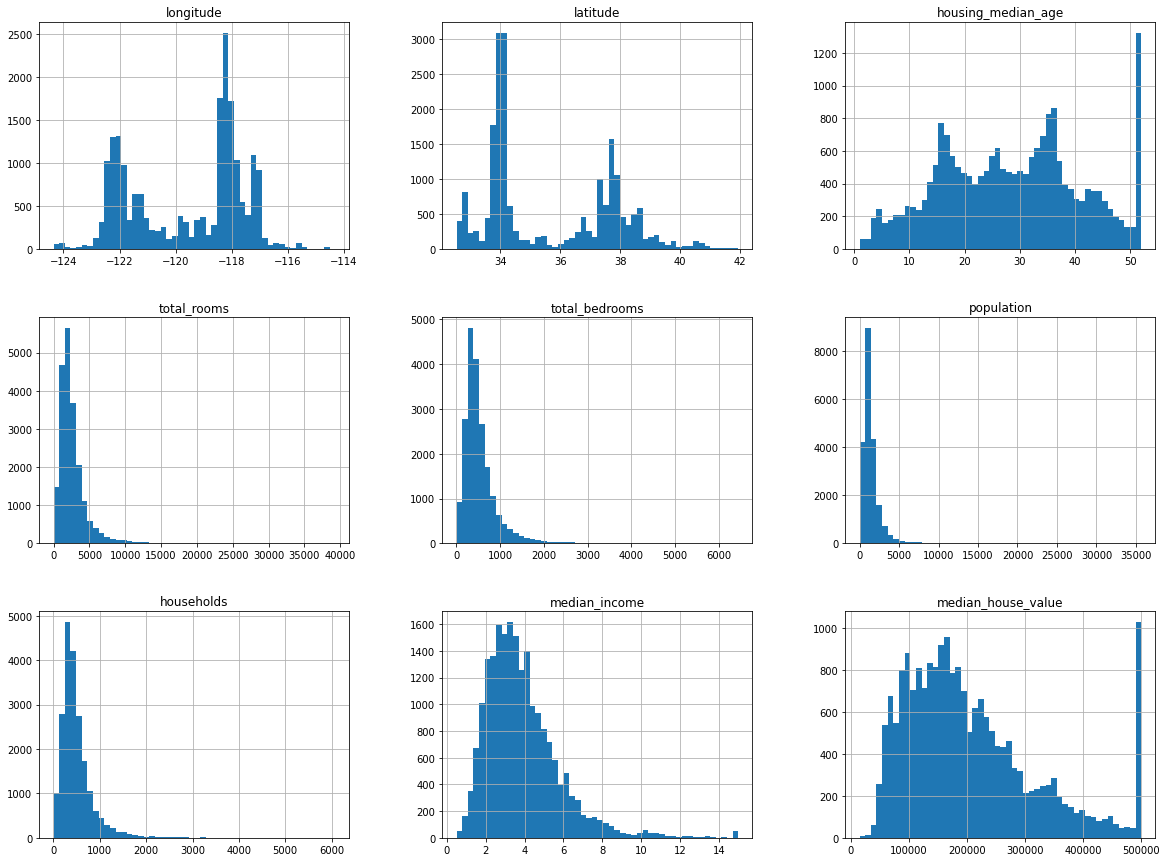

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# 몇 몇 데이터들은 전처리가 되어 있음
# median_income 의 경우, 2,4,6 형태로 표기 되었는데 전처리해서 20,000$, 40,000$, 60,000$를 표기한 것임

## 2.1 훈련/테스트 데이터 분류하기

아래 방법은 훈련/테스트 데이터를 분리할 수 있지만, 여러번 계속 시도하면 전체 데이터셋을 보는 상황이기 때문에 해당 상황을 피해줘야함

In [9]:
import numpy as np
# sckit-learn 없이 split_train_test 모듈 구현하기
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)

In [11]:
len(train_set)

16512

In [12]:
len(test_set)

4128

## 2.2 훈련/테스트 세트 서로 중복 없게 유지하기

판다스의 행 인덱스를 사용해서 데이터 분류하기

In [13]:
from zlib import crc32 # 파이썬2와의 호환을 위해 crc 모듈 사용
# 위의 split_train_test 모듈은 완벽하지 않음. 항상 같은 난수 인덱스가 생성되어야 하는데 이를 위한 안정적인 해결책은 샘플의 식별자를 사용하는 것
# 새로운 테스트 세트를 가져오되, 훈련 세트에서 사용한 샘플을 포함시키지 않는 방법
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [14]:
# 주택 데이터셋에는 식별자 칼럼이 없어서 인덱스를 ID로 사용해서 해결 가능
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
housing_with_id = housing.reset_index()

In [16]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

## 2.3 위, 경도를 사용해서 고유 식별자를 생성하는 방법도 존재

2.2번에 적용할 수 있게 식별자를 생성하는 방법은 여러가지 종류가 있음

In [17]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"] # 주택 데이터의 고유 식별자 생성하기

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

## 2.4 가장 일반적으로 사용하는 sklearn의 train_test_split 모듈

- random_state의 경우 난수 초깃값으로 42를 가장 많이 사용함.
- 특별한 의미가 있는 것은 아니고 더글러스 애덤스의 "은하수를 여행하는 히치하이커를 위한 안내스"라는 책의 슈퍼 컴퓨터가 깊은 생각이라는 질문에 대해 내놓은 답이라는 표현

In [18]:
# sklearn 모듈
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## 2.5 pd.cut()을 사용해서 계층을 나누는 작업 진행

너무 많은 계층으로 나누지 않고, 충분히 많은 각 계층으로 분리

EDA에서 Median_income 칼럼 시각화 그래프 확인

In [19]:
# 소득 기반 계층 샘플링 작업 준비
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0,1.5,3.0,4.5,6., np.inf],
                              labels=[1,2,3,4,5]
                              )

<AxesSubplot:>

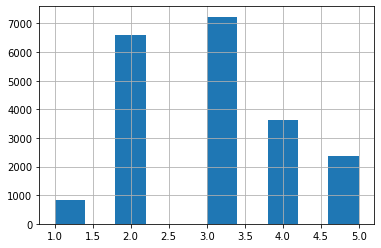

In [20]:
housing["income_cat"].hist()

## 2.6 사이킷런의 StratifiedShuffleSplit 모듈 쓰기

StratifiedShuffleSplit는 StratifiedKFold + ShuffleSplit의 랜덤 샘플링을 합친 기법으로 test_size와 train_size 매개 변수 합을 1 이하로 지정하는 것이 가능함

이 기법을 이용해 소득 카테코리의 비율을 측정

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]

In [22]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

데이터를 충분히 확인했으므로 생성한 "income_cat" 특성을 삭제해서 데이터를 원상 복구

In [23]:
for set_ in (strat_train_set, strat_test_set): # 생성한 income_cat 삭제해서 원래 데이터로 복원
    set_.drop('income_cat', axis=1, inplace=True)

## 2.7 지리 데이터 시각화

In [24]:
# 훈련 데이터를 손상시키지 않기 위해 복사본 생성
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

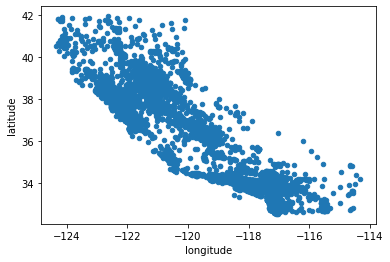

In [25]:
# 위 경도 정보가 있어서 (지리 정보) 데이터를 산점도로 시각화하는 것은 좋은 생각이다.
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

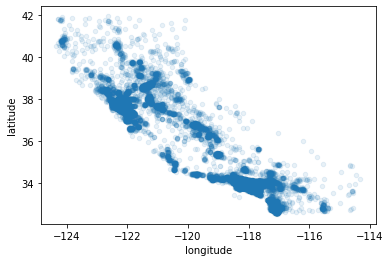

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1) # 데이터 밀도 함께 표기

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


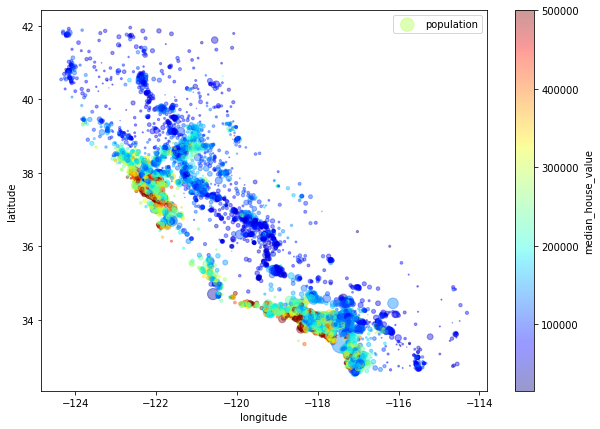

In [27]:
# 각 원의 반지름은 구역의 인구를 나타냄 (매개변수 s)
# 색상은 가격을 의미 (매개변수 c)
# 가격 범위는 jet을 사용 (매개변수 cmap)

housing.plot(kind="scatter", 
             x="longitude", y="latitude", 
             alpha=0.4, s=housing["population"]/100, 
             label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            sharex=False)
plt.legend()

## 2.8 상관관계 조사

표준 상관계수 (피어슨 r)로 특성 간의 관계 계산 (데이터셋이 너무 크지 않기 때문에 사용 가능)

In [28]:
corr_matrix = housing.corr() # 표준 상관계수 corr() 메소드

In [29]:
corr_matrix["median_house_value"].sort_values(ascending=False) # 중간 주택 가격과 다른 특성 상의 상관 관계 표기

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

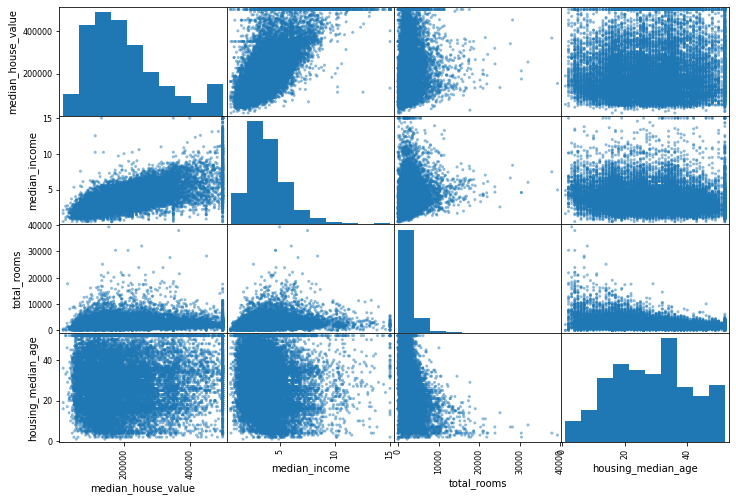

In [30]:
# 위의 11개의 숫자형 특성을 모두 그래프로 보이려면 121개 (11**2)를 보여야하는데, 화면에서 그것을 띄우기는 어려우므로
# 중간 주택 가격과 연관성이 높은 4개의 특성만 시각화
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

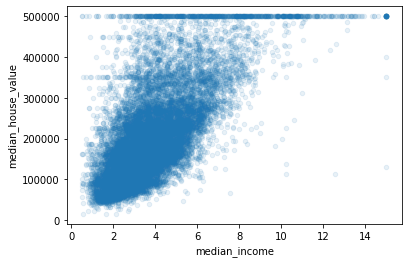

In [31]:
# median_income & median_house_value가 가장 상관 관계가 강하고 가격 제한이 500,000$로 수평선으로 되어 있음
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1) # 데이터 밀도 함께 표기

In [32]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["beds_per_rooms"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [33]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
beds_per_rooms             -0.259984
Name: median_house_value, dtype: float64

# 3. 머신러닝 알고리즘을 위한 데이터 준비

In [34]:
# 예측 변수와 레이블 분리하기

housing = strat_train_set.drop("median_house_value", axis=1)

housing_label = strat_train_set["median_house_value"].copy()

In [35]:
housing.dropna(subset=["total_bedrooms"])
housing.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [36]:
# SimpleImputer를 사용해서 누락된 값을 쉽게 채우기
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [37]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [38]:
# 각 특성의 중간값을 계산해서 그 결과를 객체의 statistics_ 속성에 저장
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [39]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [40]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [41]:
# 누락된 값을 학습한 중간 값으로 바꾸기
X = imputer.transform(housing_num)

In [42]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [43]:
housing_cat = housing[["ocean_proximity"]]

In [44]:
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [45]:
from sklearn.preprocessing import OrdinalEncoder
# 인코딩하기 (문장열 -> 숫자로 변환해서 사용)
# 이 표현 방식의 문제는 머신러닝 알고리즘이 가까이 있는 두 값이 떨어져 있는 두 값보다 더 비슷하다고 생각한다는 점.
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [46]:
# 다시 카테고리 목록으로 변환하는 방법
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [77]:
# 위의 문제를 해결하기 위해 도입한 것이 원-핫 벡터 변형인 OneHotEncoder임
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

# 출력값이 Numpy가 아니고 scipy sparse matrix임.
# 카테고리가 수천 개인 범주형 특성일 경우 매우 효율적

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [48]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [49]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [50]:
# 위의 변환기들과 같은 것을 커스터마이징해서 나만의 변환기 만들기
# Mixin -> 객체의 기능을 확장하려는 목적으로 만들어진 클래스
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_rooms=True):
        self.add_bedrooms_per_rooms = add_bedrooms_per_rooms
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_rooms:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_rooms=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [51]:
# 파이프라인 생성하기
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [52]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_label)

LinearRegression()

In [54]:
some_data = housing.iloc[:5]
some_labels = housing_label.iloc[:5]

In [55]:
some_data_prepared = full_pipeline.transform(some_data)

In [56]:
print("예측 : ", lin_reg.predict(some_data_prepared))

예측 :  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [57]:
print("레이블 : ", list(some_labels))

레이블 :  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [58]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_label, housing_predictions)

lin_rmse = np.sqrt(lin_mse)
lin_rmse # 현재 과소적합 되어 있는 상태 : 좋은 예측을 할 만큼 충분한 정보를 제공받지 못했거나 모델 성능이 충분히 강력하지 못한 것을 의미

68628.19819848923

In [59]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_label)

DecisionTreeRegressor()

In [60]:
housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_label, housing_predictions)

tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [61]:
from sklearn.model_selection import cross_val_score
# 결정트리 모델 평가 방법
# fold라 불리는 10개의 서브셋으로 무작위 분할하기
# 매번 다른 폴드를 선택해 평가하고 나머지 9개 폴드는 훈련에 사용
scores = cross_val_score(tree_reg, housing_prepared, housing_label, scoring = "neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [62]:
def display_scores(scores):
    print("score : ", scores)
    print("mean : ", scores.mean())
    print("variance : ", scores.std())

display_scores(tree_rmse_scores)

score :  [68399.44671246 68046.38135792 71360.55731505 68976.38175765
 69402.25978771 75011.40954874 70430.78971638 71266.67776106
 76103.89260861 70469.68536258]
mean :  70946.74819281655
variance :  2550.562024465052


In [63]:
# 선형 회귀 모델 평가 방법
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

score :  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean :  69052.46136345083
variance :  2731.674001798344


In [64]:
# 랜덤 포레스트는 특성을 무작위로 선택해서 많은 결정 트리를 만들고, 그 예측을 평균 내는 방식으로 작동
# 여러 다른 모델을 모아서 하나의 모델을 만드는 것을 앙상블 학습이라고 하며 머신러닝 알고리즘의 성능을 극대화하는 방법 중 하나임.
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_label)

RandomForestRegressor()

In [65]:
housing_predictions = forest_reg.predict(housing_prepared)

forest_mse = mean_squared_error(housing_label, housing_predictions)

forest_rmse = np.sqrt(forest_mse)
forest_rmse

18688.161395027128

In [66]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [67]:
display_scores(forest_rmse_scores)
# 여전히 과대 적합 되어 있음
# 과대적합 해결법 : 더 많은 훈련 데이터를 모으거나, 제한을 하거나 (규제), 모델을 간단히 만들기

score :  [49267.74452869 47469.59417268 50309.0549675  52431.26539683
 49389.96141892 53488.01246481 49090.77688858 48005.50151537
 52350.15801277 49942.61380421]
mean :  50174.46831703644
variance :  1884.434953759081


In [68]:
# model fine tuning
# 그리드 탐색은 사이킷런에서 제공하는 강력한 기능 중 하나
# 개발자가 만족할만한 하이퍼파라미터 조합을 찾을 때까지 수동으로 하이퍼파라미터 조정하는 것은 매우 지루한 일이 된다.
# 이를 위해 사이킷런에서 그리스 서치를 제공하고 있으며, 시도해볼만한 값을 지정하면 모든 하이퍼파라미터 조합에 대해 교차 검증이 진행됨.
from sklearn.model_selection import GridSearchCV

param_grid = [{"n_estimators" : [3,10,30], "max_features": [2,4,6,8]},# bootstrap : [True] 기본 설정
             {"bootstrap":[False], "n_estimators":[3,10], "max_features":[2,3,4]}
             ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True
                          )

grid_search.fit(housing_prepared, housing_label)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [69]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [70]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [71]:
cvres = grid_search.cv_results_

In [72]:
# 각 조합별 점수 확인하기.
for mean_scores, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_scores), params)

64205.72994917168 {'max_features': 2, 'n_estimators': 3}
55953.92212226707 {'max_features': 2, 'n_estimators': 10}
52939.06454604894 {'max_features': 2, 'n_estimators': 30}
59322.17430644879 {'max_features': 4, 'n_estimators': 3}
52977.32724872279 {'max_features': 4, 'n_estimators': 10}
50752.950494257486 {'max_features': 4, 'n_estimators': 30}
58710.25550643505 {'max_features': 6, 'n_estimators': 3}
52028.8992647971 {'max_features': 6, 'n_estimators': 10}
50239.46971685798 {'max_features': 6, 'n_estimators': 30}
58389.93933222789 {'max_features': 8, 'n_estimators': 3}
51815.20193415689 {'max_features': 8, 'n_estimators': 10}
50003.28688758594 {'max_features': 8, 'n_estimators': 30}
62154.354058882745 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54590.790046695154 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60152.958562270454 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52808.380664312564 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [73]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([6.98532010e-02, 6.18755062e-02, 4.13123981e-02, 1.66242670e-02,
       1.51241588e-02, 1.58315474e-02, 1.42164700e-02, 3.22050351e-01,
       5.94616016e-02, 1.13060389e-01, 7.69521576e-02, 5.60676517e-03,
       1.82700310e-01, 7.45497404e-05, 2.42263938e-03, 2.83368907e-03])

In [74]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_rooms"]

cat_encoder = full_pipeline.named_transformers_["cat"]

cat_one_hot_attribs = list(cat_encoder.categories_[0])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importance, attributes), reverse = True)

[(0.3220503505714083, 'median_income'),
 (0.1827003097689538, 'INLAND'),
 (0.11306038865883662, 'pop_per_hhold'),
 (0.07695215759627187, 'bedrooms_per_rooms'),
 (0.06985320099092143, 'longitude'),
 (0.06187550622121731, 'latitude'),
 (0.059461601551576794, 'rooms_per_hhold'),
 (0.04131239805485808, 'housing_median_age'),
 (0.016624267002811614, 'total_rooms'),
 (0.015831547419921026, 'population'),
 (0.015124158760544787, 'total_bedrooms'),
 (0.01421647003900165, 'households'),
 (0.005606765167805578, '<1H OCEAN'),
 (0.0028336890729128003, 'NEAR OCEAN'),
 (0.0024226393825542347, 'NEAR BAY'),
 (7.454974040404319e-05, 'ISLAND')]

In [75]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)

y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)

final_rmse = np.sqrt(final_mse)

In [76]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale = stats.sem(squared_errors)))

array([46139.00697644, 50079.25696728])